### Imports

In [1]:
import sys
import pickle
import numpy as np
from collections import namedtuple
from itertools import count
import random

import gym
import gym.spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

from utils.replay_buffer import ReplayBuffer
from utils.gym import get_env, get_wrapper_by_name
from utils.schedule import ConstantSchedule, PiecewiseSchedule, LinearSchedule

import matplotlib.pyplot as plt
%matplotlib inline

### Define global variables

In [2]:
BATCH_SIZE = 32
GAMMA = 0.99
REPLAY_BUFFER_SIZE = 1000000
LEARNING_STARTS = 50000
LEARNING_FREQ = 4
FRAME_HISTORY_LEN = 4
TARGET_UPDATE_FREQ = 10000
LEARNING_RATE = 0.00025
ALPHA = 0.95
EPS = 0.01
PONG = 3

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

class Variable(autograd.Variable):
    def __init__(self, data, *args, **kwargs):
        if USE_CUDA:
            data = data.cuda()
        super(Variable, self).__init__(data, *args, **kwargs)

"""
    OptimizerSpec containing following attributes
        constructor: The optimizer constructor ex: RMSprop
        kwargs: {Dict} arguments for constructing optimizer
"""
OptimizerSpec = namedtuple("OptimizerSpec", ["constructor", "kwargs"])

Statistic = {
    "mean_episode_rewards": [],
    "best_mean_episode_rewards": []
}


### Define Deep Q Network

In [3]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=18):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


### Training Function

In [4]:
def dqn_learing(
    env,
    q_func,
    optimizer_spec,
    exploration,
    stopping_criterion=None,
    replay_buffer_size=1000000,
    batch_size=32,
    gamma=0.99,
    learning_starts=50000,
    learning_freq=4,
    frame_history_len=4,
    target_update_freq=10000
    ):

    """Run Deep Q-learning algorithm.

    You can specify your own convnet using q_func.

    All schedules are w.r.t. total number of steps taken in the environment.

    Parameters
    ----------
    env: gym.Env
        gym environment to train on.
    q_func: function
        Model to use for computing the q function. It should accept the
        following named arguments:
            input_channel: int
                number of channel of input.
            num_actions: int
                number of actions
    optimizer_spec: OptimizerSpec
        Specifying the constructor and kwargs, as well as learning rate schedule
        for the optimizer
    exploration: Schedule (defined in utils.schedule)
        schedule for probability of chosing random action.
    stopping_criterion: (env) -> bool
        should return true when it's ok for the RL algorithm to stop.
        takes in env and the number of steps executed so far.
    replay_buffer_size: int
        How many memories to store in the replay buffer.
    batch_size: int
        How many transitions to sample each time experience is replayed.
    gamma: float
        Discount Factor
    learning_starts: int
        After how many environment steps to start replaying experiences
    learning_freq: int
        How many steps of environment to take between every experience replay
    frame_history_len: int
        How many past frames to include as input to the model.
    target_update_freq: int
        How many experience replay rounds (not steps!) to perform between
        each update to the target Q network
    """
    assert type(env.observation_space) == gym.spaces.Box
    assert type(env.action_space)      == gym.spaces.Discrete

    ###############
    # BUILD MODEL #
    ###############

    if len(env.observation_space.shape) == 1:
        # This means we are running on low-dimensional observations (e.g. RAM)
        input_arg = env.observation_space.shape[0]
    else:
        img_h, img_w, img_c = env.observation_space.shape
        input_arg = frame_history_len * img_c
    num_actions = env.action_space.n

    # Construct an epilson greedy policy with given exploration schedule
    def select_epilson_greedy_action(model, obs, t):
        sample = random.random()
        eps_threshold = exploration.value(t)
        if sample > eps_threshold:
            obs = torch.from_numpy(obs).type(dtype).unsqueeze(0) / 255.0
            # Use volatile = True if variable is only used in inference mode, i.e. don’t save the history
            return model(Variable(obs, volatile=True)).data.max(1)[1].cpu()
        else:
            return torch.IntTensor([[random.randrange(num_actions)]])

    # Initialize target q function and q function
    Q = q_func(input_arg, num_actions).type(dtype)
    target_Q = q_func(input_arg, num_actions).type(dtype)

    # Construct Q network optimizer function
    optimizer = optimizer_spec.constructor(Q.parameters(), **optimizer_spec.kwargs)

    # Construct the replay buffer
    replay_buffer = ReplayBuffer(replay_buffer_size, frame_history_len)

    ###############
    # RUN ENV     #
    ###############
    num_param_updates = 0
    mean_episode_reward = -float('nan')
    best_mean_episode_reward = -float('inf')
    last_obs = env.reset()
    LOG_EVERY_N_STEPS = 10000

    for t in count():
        ### Check stopping criterion
        if stopping_criterion is not None and stopping_criterion(env):
            break

        ### Step the env and store the transition
        # Store lastest observation in replay memory and last_idx can be used to store action, reward, done
        last_idx = replay_buffer.store_frame(last_obs)
        # encode_recent_observation will take the latest observation
        # that you pushed into the buffer and compute the corresponding
        # input that should be given to a Q network by appending some
        # previous frames.
        recent_observations = replay_buffer.encode_recent_observation()

        # Choose random action if not yet start learning
        if t > learning_starts:
            action = select_epilson_greedy_action(Q, recent_observations, t)[0, 0]
        else:
            action = random.randrange(num_actions)
        # Advance one step
        obs, reward, done, _ = env.step(action)
        # clip rewards between -1 and 1
        reward = max(-1.0, min(reward, 1.0))
        # Store other info in replay memory
        replay_buffer.store_effect(last_idx, action, reward, done)
        # Resets the environment when reaching an episode boundary.
        if done:
            obs = env.reset()
        last_obs = obs

        ### Perform experience replay and train the network.
        # Note that this is only done if the replay buffer contains enough samples
        # for us to learn something useful -- until then, the model will not be
        # initialized and random actions should be taken
        if (t > learning_starts and
                t % learning_freq == 0 and
                replay_buffer.can_sample(batch_size)):
            # Use the replay buffer to sample a batch of transitions
            # Note: done_mask[i] is 1 if the next state corresponds to the end of an episode,
            # in which case there is no Q-value at the next state; at the end of an
            # episode, only the current state reward contributes to the target
            obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = replay_buffer.sample(batch_size)
            # Convert numpy nd_array to torch variables for calculation
            obs_batch = Variable(torch.from_numpy(obs_batch).type(dtype) / 255.0)
            act_batch = Variable(torch.from_numpy(act_batch).long())
            rew_batch = Variable(torch.from_numpy(rew_batch))
            next_obs_batch = Variable(torch.from_numpy(next_obs_batch).type(dtype) / 255.0)
            not_done_mask = Variable(torch.from_numpy(1 - done_mask)).type(dtype)

            if USE_CUDA:
                act_batch = act_batch.cuda()
                rew_batch = rew_batch.cuda()

            # Compute current Q value, q_func takes only state and output value for every state-action pair
            # We choose Q based on action taken.
            current_Q_values = Q(obs_batch).gather(1, act_batch.unsqueeze(1))
            # Compute next Q value based on which action gives max Q values
            # Detach variable from the current graph since we don't want gradients for next Q to propagated
            next_max_q = target_Q(next_obs_batch).detach().max(1)[0]
            next_Q_values = not_done_mask * next_max_q
            # Compute the target of the current Q values
            target_Q_values = rew_batch + (gamma * next_Q_values)
            # Compute Bellman error
            bellman_error = target_Q_values - current_Q_values
            # clip the bellman error between [-1 , 1]
            clipped_bellman_error = bellman_error.clamp(-1, 1)
            # Note: clipped_bellman_delta * -1 will be right gradient
            d_error = clipped_bellman_error * -1.0
            # Clear previous gradients before backward pass
            optimizer.zero_grad()
            # run backward pass
            current_Q_values.backward(d_error.data.unsqueeze(1))

            # Perfom the update
            optimizer.step()
            num_param_updates += 1

            # Periodically update the target network by Q network to target Q network
            if num_param_updates % target_update_freq == 0:
                target_Q.load_state_dict(Q.state_dict())

        ### 4. Log progress and keep track of statistics
        episode_rewards = get_wrapper_by_name(env, "Monitor").get_episode_rewards()
        if len(episode_rewards) > 0:
            mean_episode_reward = np.mean(episode_rewards[-100:])
        if len(episode_rewards) > 100:
            best_mean_episode_reward = max(best_mean_episode_reward, mean_episode_reward)

        Statistic["mean_episode_rewards"].append(mean_episode_reward)
        Statistic["best_mean_episode_rewards"].append(best_mean_episode_reward)

        if t % LOG_EVERY_N_STEPS == 0 and t > learning_starts:
            print("Timestep %d" % (t,))
            print("mean reward (100 episodes) %f" % mean_episode_reward)
            print("best mean reward %f" % best_mean_episode_reward)
            print("episodes %d" % len(episode_rewards))
            print("exploration %f" % exploration.value(t))
            sys.stdout.flush()

            # Dump statistics to pickle
            with open('statistics.pkl', 'wb') as f:
                pickle.dump(Statistic, f)
                print("Saved to %s" % 'results/statistics.pkl')

### Main Function

In [ ]:
if __name__ == '__main__':
    
    ## Set Gym
    # Get Atari games.
    atari = gym.benchmark_spec('Atari40M')

    # Change the index to select a different game.
    task = atari.tasks[PONG]
    num_timesteps = task.max_timesteps
    
    ## Run training
    seed = 0        # Use a seed of zero
    env = get_env(task, seed)
    
    def stopping_criterion(env):
        # notice that here t is the number of steps of the wrapped env,
        # which is different from the number of steps in the underlying env
        return get_wrapper_by_name(env, "Monitor").get_total_steps() >= num_timesteps
    
    optimizer_spec = OptimizerSpec(
        constructor=optim.RMSprop,
        kwargs=dict(lr=LEARNING_RATE, alpha=ALPHA, eps=EPS),
    )
    
    exploration_schedule = LinearSchedule(1000000, 0.1)
    
    dqn_learing(
        env=env,
        q_func=DQN,
        optimizer_spec=optimizer_spec,
        exploration=exploration_schedule,
        stopping_criterion=stopping_criterion,
        replay_buffer_size=REPLAY_BUFFER_SIZE,
        batch_size=BATCH_SIZE,
        gamma=GAMMA,
        learning_starts=LEARNING_STARTS,
        learning_freq=LEARNING_FREQ,
        frame_history_len=FRAME_HISTORY_LEN,
        target_update_freq=TARGET_UPDATE_FREQ,
    )



[2017-07-14 09:40:05,419] Making new env: PongNoFrameskip-v4
[2017-07-14 09:40:05,840] Clearing 14 monitor files from previous run (because force=True was provided)
[2017-07-14 09:40:07,897] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000000.mp4
[2017-07-14 09:40:11,194] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000001.mp4
[2017-07-14 09:40:22,678] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000008.mp4
[2017-07-14 09:40:51,171] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000027.mp4
[2017-07-14 09:41:54,521] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000064.mp4


Timestep 60000
mean reward (100 episodes) -20.312500
best mean reward -inf
episodes 64
exploration 0.946000
Saved to results/statistics.pkl
Timestep 70000
mean reward (100 episodes) -20.266667
best mean reward -inf
episodes 75
exploration 0.937000
Saved to results/statistics.pkl
Timestep 80000
mean reward (100 episodes) -20.197674
best mean reward -inf
episodes 86
exploration 0.928000
Saved to results/statistics.pkl
Timestep 90000
mean reward (100 episodes) -20.237113
best mean reward -inf
episodes 97
exploration 0.919000
Saved to results/statistics.pkl
Timestep 100000
mean reward (100 episodes) -20.220000
best mean reward -20.200000
episodes 107
exploration 0.910000
Saved to results/statistics.pkl
Timestep 110000
mean reward (100 episodes) -20.200000
best mean reward -20.200000
episodes 118
exploration 0.901000
Saved to results/statistics.pkl


[2017-07-14 09:45:43,763] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000125.mp4


Timestep 120000
mean reward (100 episodes) -20.170000
best mean reward -20.170000
episodes 129
exploration 0.892000
Saved to results/statistics.pkl
Timestep 130000
mean reward (100 episodes) -20.170000
best mean reward -20.150000
episodes 140
exploration 0.883000
Saved to results/statistics.pkl
Timestep 140000
mean reward (100 episodes) -20.130000
best mean reward -20.130000
episodes 150
exploration 0.874000
Saved to results/statistics.pkl
Timestep 150000
mean reward (100 episodes) -20.130000
best mean reward -20.120000
episodes 161
exploration 0.865000
Saved to results/statistics.pkl
Timestep 160000
mean reward (100 episodes) -20.150000
best mean reward -20.120000
episodes 172
exploration 0.856000
Saved to results/statistics.pkl
Timestep 170000
mean reward (100 episodes) -20.220000
best mean reward -20.120000
episodes 183
exploration 0.847000
Saved to results/statistics.pkl
Timestep 180000
mean reward (100 episodes) -20.250000
best mean reward -20.120000
episodes 194
exploration 0.838

[2017-07-14 09:49:53,906] Starting new video recorder writing to /users/aditya.a/cvit_schools/cvitmlss17/lab5/results/pong/openaigym.video.0.16263.video000216.mp4


Timestep 200000
mean reward (100 episodes) -20.270000
best mean reward -20.120000
episodes 216
exploration 0.820000
Saved to results/statistics.pkl
Timestep 210000
mean reward (100 episodes) -20.330000
best mean reward -20.120000
episodes 227
exploration 0.811000
Saved to results/statistics.pkl


### Plots

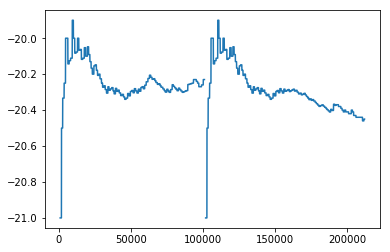

In [8]:
plt.plot(Statistic["mean_episode_rewards"])

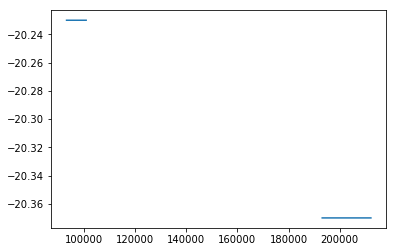

In [10]:
plt.plot(Statistic["best_mean_episode_rewards"])